在发电厂数据集上训练并评估线性回归模型。

本模块遵循实验指南中描述的工作流程：
1. 加载包含天气观测值及对应发电功率的 ``Folds5x2_pp.csv`` 数据集。
2. 将数据集划分为训练集和测试集。
3. 使用训练数据训练 :class:`~sklearn.linear_model.LinearRegression` 模型。
4. 使用常见的回归指标评估模型。
5. 可视化预测值与真实发电功率之间的关系。

In [6]:
# %matplotlib inline # 确保图像在 Notebook 中内联显示
from __future__ import annotations

import argparse # 保留导入以防函数内部仍需引用，但不再用于解析
from dataclasses import dataclass
from pathlib import Path
from typing import Iterable

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [7]:
DATASET_FILENAME = "Folds5x2_pp.csv"

@dataclass
class ModelResult:
    """用于保存模型评估结果的容器。"""

    model: LinearRegression
    y_test: pd.Series
    predictions: np.ndarray
    mse: float
    rmse: float
    mae: float
    r2: float

In [8]:
def default_dataset_path() -> Path:
    """返回仓库中数据集的默认位置。
    
    注意: 在 Notebook 环境中，__file__ 可能不可靠。
    如果下面的路径不正确，请在参数模拟单元格中手动指定正确的路径。
    """
    # 假设 Notebook 文件保存在 'src' 目录下，数据在上一级的 'data' 目录下
    # 如果 Notebook 文件位置不同，需要相应调整
    try:
        # 尝试使用 __file__ (可能在某些环境中有效)
        base_path = Path(__file__).resolve().parent
    except NameError:
        # 如果 __file__ 未定义 (常见于某些 Notebook 环境), 退回到当前工作目录
        print("Warning: __file__ not defined, using current working directory relative path. Ensure 'data' folder is accessible.")
        base_path = Path(".").resolve() # 使用当前工作目录
        
    # 假设 'src' 和 'data' 是同级目录
    # 如果 Notebook 在 src 目录下，向上退一级
    if base_path.name == 'src':
         return base_path.parent / "data" / DATASET_FILENAME
    else: # 假设 Notebook 在项目根目录，数据在 'data' 子目录
         return base_path / "data" / DATASET_FILENAME


def load_dataset(path: Path) -> pd.DataFrame:
    """加载发电厂数据集。

    参数
    ----------
    path:
        指向包含数据集的 CSV 文件的路径。

    返回值
    -------
    pandas.DataFrame
        包含预期特征列（AT、V、AP、RH）和目标列（PE）的数据集。
    """

    if not path.is_file():
        raise FileNotFoundError(f"Dataset file not found at: {path}")
        
    data = pd.read_csv(path)
    expected_columns = {"AT", "V", "AP", "RH", "PE"}
    missing_columns = expected_columns.difference(data.columns)
    if missing_columns:
        missing = ", ".join(sorted(missing_columns))
        raise ValueError(
            f"Dataset at {path} is missing the following required columns: {missing}"
        )

    return data


def split_features_and_target(data: pd.DataFrame) -> tuple[pd.DataFrame, pd.Series]:
    """将数据框拆分为特征（X）和目标（y）。"""

    feature_columns: list[str] = ["AT", "V", "AP", "RH"]
    target_column = "PE"
    X = data[feature_columns]
    y = data[target_column]
    return X, y


def train_model(
    X: pd.DataFrame,
    y: pd.Series,
    test_size: float,
    random_state: int,
) -> ModelResult:
    """训练线性回归模型并在测试集上进行评估。"""

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    model = LinearRegression()
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = float(np.sqrt(mse))
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    return ModelResult(
        model=model,
        y_test=y_test,
        predictions=predictions,
        mse=float(mse),
        rmse=rmse,
        mae=float(mae),
        r2=float(r2),
    )


def plot_predictions(
    y_true: Iterable[float],
    y_pred: Iterable[float],
    save_path: Path | None = None,
    show_plot: bool = False,
) -> None:
    """生成比较真实值和预测值的散点图。"""
    
    # y_true 可能是 pandas Series, y_pred 是 numpy array, 直接用 np.asarray 即可
    y_true_np = np.asarray(y_true) 
    y_pred_np = np.asarray(y_pred)

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(y_true_np, y_pred_np, color="#1f77b4", edgecolor="black", alpha=0.8, label='Predictions') # 添加标签

    min_val = min(y_true_np.min(), y_pred_np.min())
    max_val = max(y_true_np.max(), y_pred_np.max())
    ax.plot([min_val, max_val], [min_val, max_val], "--", color="tab:red", label="Ideal fit")

    ax.set_title("Linear Regression: Actual vs. Predicted Power Output")
    ax.set_xlabel("Actual Power Output (PE)")
    ax.set_ylabel("Predicted Power Output (PE)")
    ax.grid(True, linestyle=":", linewidth=0.5)
    ax.legend()

    if save_path is not None:
        print(f"Attempting to save plot to: {save_path.resolve()}")
        try:
            save_path.parent.mkdir(parents=True, exist_ok=True)
            fig.savefig(save_path, bbox_inches="tight")
            print("Plot saved successfully.")
        except Exception as e:
             print(f"Error saving plot: {e}")

    if show_plot: # 在 Notebook 中，通常不需要显式调用 show()，除非 %matplotlib inline 未设置
        plt.show()
        
    # 在 Notebook 中通常不需要显式关闭，除非你想释放内存且不显示
    # else:
    #     plt.close(fig)

In [9]:
# --- 参数模拟单元格 ---
# 替换原脚本中的 argparse 部分

# 指定数据集路径。如果 default_dataset_path() 工作不正常，请手动修改此路径！
# 例如: data_path = Path('../data/Folds5x2_pp.csv') # 如果 Notebook 在 src 目录下
# 或者: data_path = Path('./data/Folds5x2_pp.csv') # 如果 Notebook 和 data 文件夹同级
try:
    data_path = default_dataset_path()
    # 检查路径是否存在，如果不存在则提示用户修改
    if not data_path.is_file():
      print(f"Warning: Default data path {data_path} not found. Please modify 'data_path' manually in this cell.")
      # 在这里可以设置一个备用路径或让用户输入
      # data_path = Path('path/to/your/Folds5x2_pp.csv') 
except Exception as e:
     print(f"Error determining default data path: {e}. Please set 'data_path' manually.")
     # 设置一个明确的占位符或引发错误
     data_path = Path('PLEASE_SET_DATA_PATH/Folds5x2_pp.csv') 
     
print(f"Using data path: {data_path}")

# 设置其他参数 (使用原脚本的默认值)
test_size = 0.25
random_state = 42
save_plot_path = Path("plots/actual_vs_predicted.png")
show_plot_flag = True # 在 Notebook 中通常希望直接看到图像

Using data path: C:\Users\陈璟\Linear-Regression-2\data\Folds5x2_pp.csv


Loading dataset from C:\Users\陈璟\Linear-Regression-2\data\Folds5x2_pp.csv...
Dataset loaded successfully.
Splitting features and target...
Features shape: (9568, 4), Target shape: (9568,)
Training model with test_size=0.25, random_state=42...
Model training and evaluation complete.

Model coefficients:
   AT: -1.9785
    V: -0.2340
   AP:  0.0583
   RH: -0.1591
Intercept:  458.5564

Evaluation metrics on the test set:
  Mean Squared Error (MSE): 20.0714
  Root Mean Squared Error (RMSE): 4.4801
  Mean Absolute Error (MAE): 3.5872
  R^2 Score: 0.9303

Generating plot...
Attempting to save plot to: C:\Users\陈璟\Linear-Regression-2\plots\actual_vs_predicted.png
Plot saved successfully.


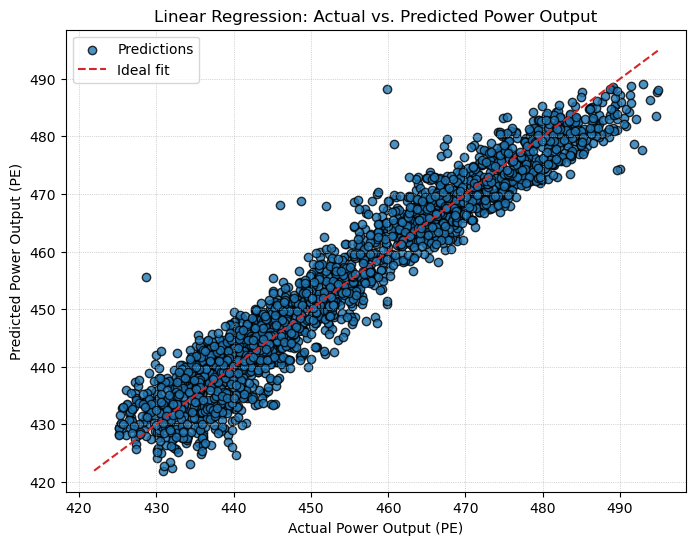


Scatter plot saved to: C:\Users\陈璟\Linear-Regression-2\plots\actual_vs_predicted.png


In [10]:
# --- 主逻辑单元格 ---
# 运行核心的训练和评估流程

try:
    print(f"Loading dataset from {data_path}...")
    data = load_dataset(data_path)
    print("Dataset loaded successfully.")
    
    print("Splitting features and target...")
    X, y = split_features_and_target(data)
    print(f"Features shape: {X.shape}, Target shape: {y.shape}")

    print(f"Training model with test_size={test_size}, random_state={random_state}...")
    result = train_model(X, y, test_size=test_size, random_state=random_state)
    print("Model training and evaluation complete.")

    print("\nModel coefficients:")
    for feature_name, coefficient in zip(X.columns, result.model.coef_):
        print(f"  {feature_name:>3}: {coefficient: .4f}")
    print(f"Intercept: {result.model.intercept_: .4f}")

    print("\nEvaluation metrics on the test set:")
    print(f"  Mean Squared Error (MSE): {result.mse:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {result.rmse:.4f}")
    print(f"  Mean Absolute Error (MAE): {result.mae:.4f}")
    print(f"  R^2 Score: {result.r2:.4f}")

    print("\nGenerating plot...")
    plot_predictions(
        result.y_test,
        result.predictions,
        save_path=save_plot_path,
        show_plot=show_plot_flag, # 使用模拟参数
    )
    # 打印保存路径（如果保存了）
    if save_plot_path is not None:
        print(f"\nScatter plot saved to: {save_plot_path.resolve()}")
        
except FileNotFoundError as e:
    print(f"\nError: {e}")
    print("Please ensure the data file path is correct in the '参数模拟单元格'.")
except ValueError as e:
    print(f"\nError processing data: {e}")
except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")
